In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from math import radians, degrees, cos

In [2]:
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

In [3]:

# Read the Excel file
file_path = "C:/Users/JB/Documents/SARH Data 2015-2021.xlsx"
data = pd.read_excel(file_path, sheet_name = "2020_21")

# Select the columns of interest
coords = data[["Latitude", "Longitude"]]

# Drop rows with missing values in either latitude or longitude
coords = coords.dropna(subset=["Latitude", "Longitude"])

# Create a geometry column from the latitudes and longitudes
geometry = [Point(xy) for xy in zip(coords["Longitude"], coords["Latitude"])]

# Convert the DataFrame to a GeoDataFrame
gdf = GeoDataFrame(coords, geometry=geometry, crs="EPSG:4326")

In [4]:
#Defining areas of interest
areas_of_interest = {
    'Ben Nevis': (-5.0000, 56.7969),
    'Snowdonia': (-3.8986, 53.0685),
    'Lake District': (-3.1070, 54.4609),
    'Beachy Head': (0.2474, 50.7389),
    'Isles of Scilly': (-6.3115, 49.9135),
    'Isle of Wight': (-1.2976, 50.7084),
    'Lyme Bay': (-3.0116, 50.6850)
}

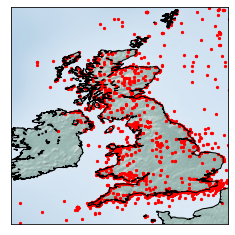

In [5]:


# Set the extent to cover the UK
uk_extent = [-10.0, 2.0, 49.0, 61.0]

# Create Basemap instance
m = Basemap(
    projection="cyl",
    resolution="h",
    llcrnrlat=uk_extent[2],
    urcrnrlat=uk_extent[3],
    llcrnrlon=uk_extent[0],
    urcrnrlon=uk_extent[1],
)

# Add shaded relief background
m.shadedrelief(alpha=0.8)

# Add coastline
m.drawcoastlines(linewidth=1)

# Plot the points from the GeoDataFrame on the map
lons, lats = gdf["Longitude"].to_numpy(), gdf["Latitude"].to_numpy()
x, y = m(lons, lats)
m.scatter(x, y, s=5, color="red", marker="o")


In [6]:
# Function to create a Basemap instance for a specific extent
def create_basemap(ax, extent, resolution='h'):
    m = Basemap(
        projection='cyl',
        resolution=resolution,
        llcrnrlat=extent[2],
        urcrnrlat=extent[3],
        llcrnrlon=extent[0],
        urcrnrlon=extent[1],
        ax=ax
    )
    m.shadedrelief(alpha=0.8)
    m.drawcoastlines(linewidth=1)
    return m

# Calculate the zoomed extent in degrees based on a fixed distance in kilometers
def calculate_zoomed_extent(lon, lat, distance_km):
    earth_radius_km = 6371

    # Convert the distance to degrees
    dlat = degrees(distance_km / earth_radius_km)
    dlon = degrees(distance_km / (earth_radius_km * cos(radians(lat))))
    
    return [lon - dlon, lon + dlon, lat - dlat, lat + dlat]


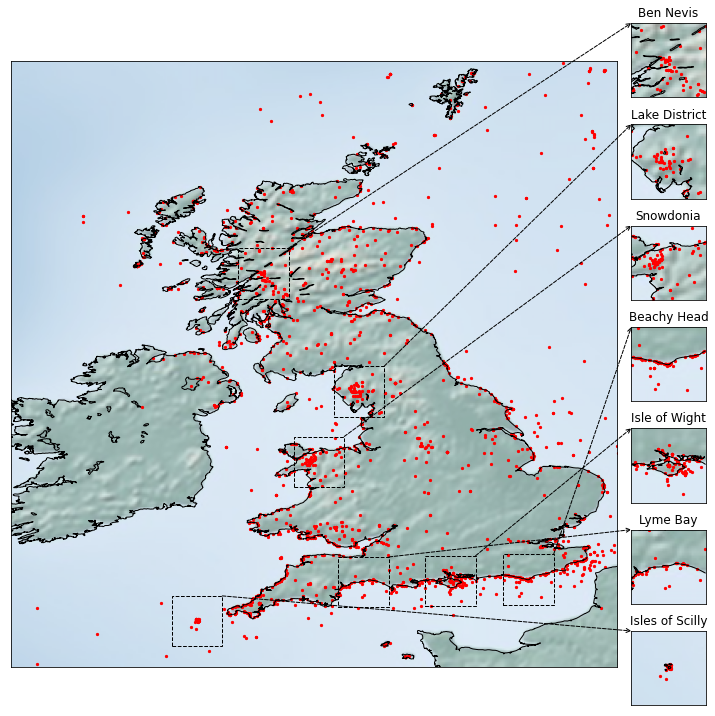

In [7]:


# Create main map
fig = plt.figure(figsize=(10, 10))
n = len(areas_of_interest)
gs = GridSpec(n, n + 1)

ax = plt.subplot(gs[:, :-1])
main_map = create_basemap(ax, uk_extent)
x, y = main_map(lons, lats)
main_map.scatter(x, y, s=5, color='red', marker='o')
# Sort areas_of_interest by latitude, from north to south
sorted_areas = sorted(areas_of_interest.items(), key=lambda x: x[1][1], reverse=True)

# Loop through sorted areas of interest
for i, (area, (lon, lat)) in enumerate(sorted_areas):
    # Calculate the extent of the zoomed area
    zoom_level = 0.5
    extent = [lon - zoom_level, lon + zoom_level, lat - zoom_level, lat + zoom_level]
    
    # Create zoomed subplot
    sax = plt.subplot(gs[i, -1])
    sub_map = create_basemap(sax, extent, resolution='f')
    sax.set_title(area)
    
    # Plot the points from the GeoDataFrame within the extent
    sub_gdf = gdf.cx[extent[0]:extent[1], extent[2]:extent[3]]
    sub_lons, sub_lats = sub_gdf["Longitude"].to_numpy(), sub_gdf["Latitude"].to_numpy()
    x, y = sub_map(sub_lons, sub_lats)
    sub_map.scatter(x, y, s=5, color='red', marker='o')

    # Add rectangle and connection patch
    rect_lon_min, rect_lat_min = main_map(lon - zoom_level, lat - zoom_level)
    rect_lon_max, rect_lat_max = main_map(lon + zoom_level, lat + zoom_level)
    rect = Rectangle((rect_lon_min, rect_lat_min), rect_lon_max - rect_lon_min, rect_lat_max - rect_lat_min, edgecolor='black', facecolor='none', linestyle='--', linewidth=1)
    ax.add_patch(rect)

    con = ConnectionPatch(xyA=(rect_lon_max, rect_lat_max), coordsA=ax.transData, xyB=(0, 1), coordsB=sax.transAxes, linestyle='--', linewidth=1, arrowstyle='->')
    fig.add_artist(con)
    
# Save and display the plot
plt.tight_layout()

In [9]:
import math
